In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pymc3 as pm

## 1. Implementación del modelo Beta-Binomial para la moneda

#### Caso uniforme: B(1,1)
Para modelar el _prior_ $\theta$ utilizaremos en este caso, una distribución Beta con sus parámetros $\alpha$ y $\beta$ iguales a 1, lo que es equivalente a una distribución normal (N(0,1)). Por su parte para modelar $k$ utilizaremos una distribución binomial.
<br>
Se implementarán las distribuciones mencionadas para el experimento de arrojar una moneda al aire 6 veces y en todas ellas se obtuvo "cara".

In [4]:
#vemos que B(1,1) es uniforme 
model_uniform = pm.Model()
with model_uniform:
    theta_uniform = pm.Beta('theta uniforme', 1, 1)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:02<00:00, 342.84it/s]


(array([ 59.,  44.,  41.,  47.,  44.,  54.,  43.,  42.,  50.,  76.]),
 array([  3.55457602e-04,   1.00122850e-01,   1.99890242e-01,
          2.99657634e-01,   3.99425026e-01,   4.99192418e-01,
          5.98959810e-01,   6.98727203e-01,   7.98494595e-01,
          8.98261987e-01,   9.98029379e-01]),
 <a list of 10 Patch objects>)

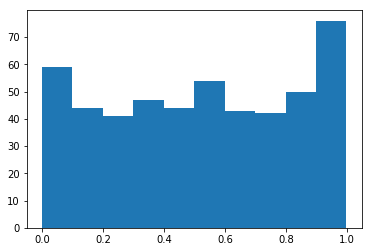

In [5]:
hist([t['theta uniforme'] for t in trace.points()])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1127.49it/s]


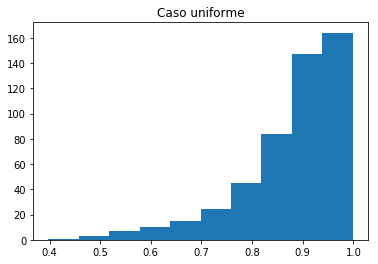

In [51]:
model_uniform = pm.Model()
with model_uniform:
    theta = pm.Beta('theta_uniform', 1, 1)
    tiradas = pm.Binomial('tiradas', n=6, p=theta, observed=6)
    trace = pm.sample()
hist(trace.theta_uniform)
title('Caso uniforme')

A partir de un $\theta$ uniforme se obtuvo que el _posterior_ (p($\theta$|$k$)) indicaría que la moneda está cargada.

#### Caso Honesto: B(100,100)

En este caso el _prior_ se modelará teniendo en cuenta que la probabilidad de sacar "cara" o "ceca" al arrojar la moneda es 0.5 en ambos casos. Es decir, se asume una "moneda honesta".
<br>
Se implementarán las distribuciones mencionadas para el experimento de arrojar una moneda al aire 6 veces y en todas ellas se obtuvo "cara".

In [12]:
#vemos que la distribucion se centra en 0.5
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)  # TODO: NUTS no funciona con 100, 100
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1183.30it/s]


(array([   2.,   11.,   41.,   65.,  108.,  132.,   66.,   54.,   13.,    8.]),
 array([ 0.3490402 ,  0.37881435,  0.4085885 ,  0.43836265,  0.4681368 ,
         0.49791095,  0.52768509,  0.55745924,  0.58723339,  0.61700754,
         0.64678169]),
 <a list of 10 Patch objects>)

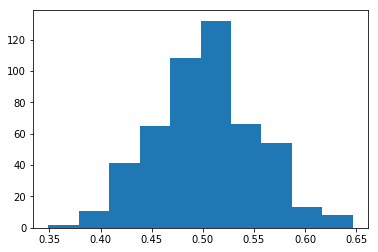

In [13]:
hist([t['theta_honest'] for t in trace.points()])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1176.72it/s]


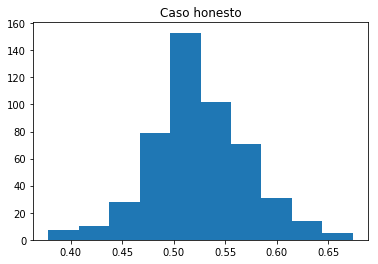

In [52]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)  # TODO: cambiar a 100, 100 cuando sepamos como
    tiradas = pm.Binomial('tiradas', n=6, p=theta_honest, observed=6)
    trace = pm.sample()
hist(trace.theta_honest)
title('Caso honesto')

En este caso,a  diferencia del anterior, no se asume desde un primer momento que la moneda está cargada y eso mismo se ve reflejado en la probabilidad p($\theta$|$k$).

In [63]:
trace.point(10)

{'beta': 0.49665140461576607,
 'beta_logodds__': -0.013394581798884891,
 'tiradas': 4}

## 2. MAP y medias de las distribuciones

Para lograr una mejor descripción de las probabilidades encontradas en los dos casos de estudio, se calculan el Máximo A Posteriori y las medias.

#### Caso Uniforme

In [15]:
model_uniform = pm.Model()
with model_uniform:
    theta_uniform = pm.Beta('theta_uniform', 1, 1)
    tiradas = pm.Binomial('tiradas', p=theta_uniform, n=6, observed=6)
    trace = pm.sample()
    MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1155.23it/s]
logp = -0.0023631, ||grad|| = 0.0023627: 100%|██████████| 20/20 [00:00<00:00, 1213.05it/s] 


In [16]:
print('MAP Estimate para beta(1, 1): {}'.format(MAP['theta_uniform']))

MAP Estimate para beta(1, 1): 0.9999984620831801


In [17]:
print('Media para beta(1, 1): {}'.format(mean(trace.theta_uniform)))

Media para beta(1, 1): 0.8773423515808103


#### Caso Honesto

In [18]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)  # TODO
    tiradas = pm.Binomial('tiradas', p=theta_honest, n=6, observed=6)
    trace = pm.sample()
    MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1176.11it/s]
logp = -2.0846, ||grad|| = 3: 100%|██████████| 6/6 [00:00<00:00, 1293.81it/s]


In [19]:
print('MAP Estimate para beta(50, 50): {}'.format(MAP['theta_honest']))

MAP Estimate para beta(50, 50): 0.5288461537406147


In [20]:
print('Media para beta(50, 50): {}'.format(mean(trace.theta_honest)))

Media para beta(50, 50): 0.5272513239222776


## 3. Predicción

Aquí se querrá predecir el resultado de un próximo lanzamiento de moneda teniendo en cuenta la información ya modelada.

#### Caso uniforme

In [53]:
model_uniform = pm.Model()
with model_uniform:
    theta_uniform = pm.Beta('theta_uniform', 1, 1)
    dato = pm.Binomial('dato', p=theta_uniform, n=6, observed=6)
    post_uniform = pm.Binomial('post_uniform', p=theta_uniform, n=6)
    trace = pm.sample()

Assigned NUTS to theta_uniform_logodds__
Assigned Metropolis to post_uniform
 95%|█████████▌| 954/1000 [00:01<00:00, 554.65it/s]/home/stella/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:01<00:00, 556.10it/s]


In [90]:
trace.varnames

['theta_logodds__', 'post', 'theta']

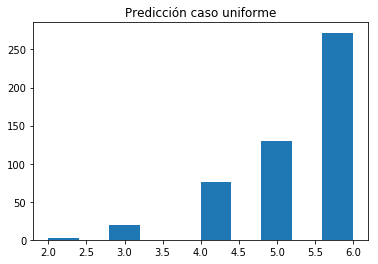

In [54]:
hist(trace.post_uniform)
title('Predicción caso uniforme')

Teniendo en cuenta el _prior_ que asume que la moneda está cargada, la predicción que se obtiene se ve completamente influenciada resultando mayor la probabilidad que vuelva a salir cara en el próximo lanzamiento.

#### Caso honesto 

In [55]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)
    dato = pm.Binomial('dato', p=theta_honest, n=6, observed=6)
    post_honest = pm.Binomial('post_honest', p=theta_honest, n=6)
    trace = pm.sample()

Assigned NUTS to theta_honest_logodds__
Assigned Metropolis to post_honest
100%|██████████| 1000/1000 [00:01<00:00, 557.92it/s]


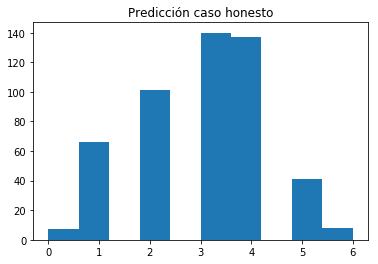

In [56]:
hist(trace.post_honest)
title('Predicción caso honesto')

Como era de esperarse, con el _prior_ de moneda honesta, la predicción para el resultado del próximo lanzamiento no indica que volverá a obtenerse una cara.

## 4. Comparaciones entre datos

Con el objetivo de analizar cuánto influyen los datos iniciales y las creencias que son asumidas en el _prior_ se pondrán a prueba dos experimentos que se diferencian en la cantidad de tiradas y resultados obtenidos.

TODO: se podria hacer una funcion que haga lo mismo que en los puntos anteriores y aca solo le cambiamos el n y el k (3, 20). 

### Experimento 1: 20 tiradas, 20 caras

#### Caso uniforme

In [42]:
model_uniform = pm.Model()
with model_uniform:
    theta_uniform = pm.Beta('theta_uniform', 1, 1)
    tiradas = pm.Binomial('tiradas', p=theta_uniform, n=20, observed=20)
    post_uniform = pm.Binomial('post_uniform', p=theta_uniform, n=20)
    trace = pm.sample()
    MAP = pm.find_MAP()

Assigned NUTS to theta_uniform_logodds__
Assigned Metropolis to post_uniform
 98%|█████████▊| 985/1000 [00:01<00:00, 523.89it/s]/home/stella/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:01<00:00, 521.43it/s]
logp = -15.599, ||grad|| = 10: 100%|██████████| 7/7 [00:00<00:00, 1184.54it/s]


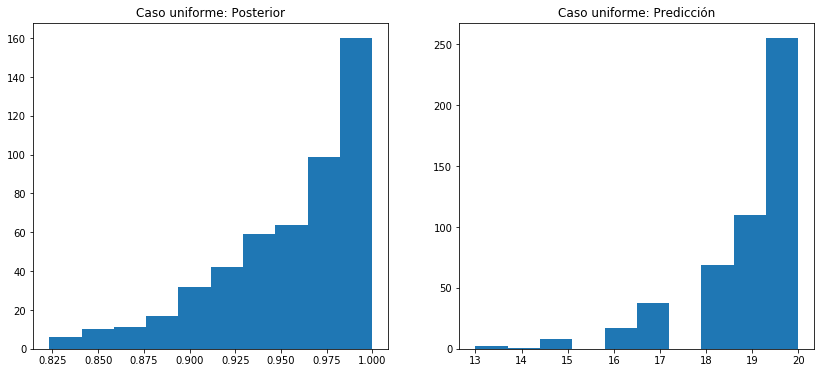

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(axs[0])
hist(trace.theta_uniform)
title('Caso uniforme: Posterior')

plt.sca(axs[1])
hist(trace.post_uniform)
title('Caso uniforme: Predicción')

In [27]:
print('MAP Estimate para beta(1, 1): {}'.format(MAP['theta_uniform']))
print('Media para beta(1, 1): {}'.format(mean(trace.theta_uniform)))

MAP Estimate para beta(1, 1): 0.9999996155210419
Media para beta(1, 1): 0.9529261920092479


sube la media

#### Caso honesto

In [48]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)  # TODO
    tiradas = pm.Binomial('tiradas', p=theta_honest, n=20, observed=20)
    post_honest = pm.Binomial('post_honest', p=theta_honest, n=20)
    trace = pm.sample()
    MAP = pm.find_MAP()

Assigned NUTS to theta_honest_logodds__
Assigned Metropolis to post_honest
100%|██████████| 1000/1000 [00:01<00:00, 588.23it/s]
logp = -13.525, ||grad|| = 10: 100%|██████████| 6/6 [00:00<00:00, 1015.98it/s]


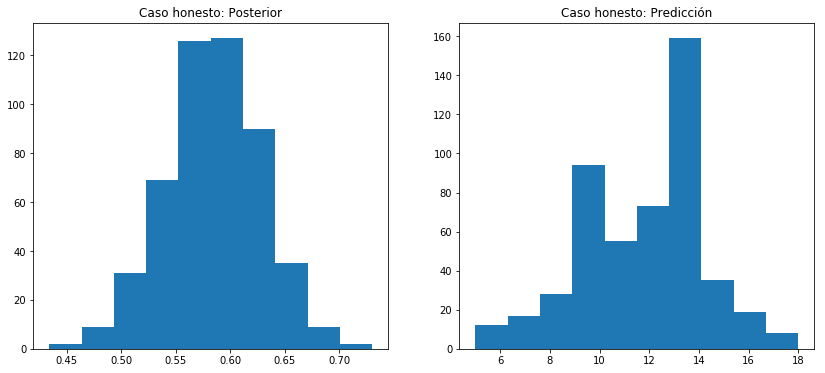

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(axs[0])
hist(trace.theta_honest)
title('Caso honesto: Posterior')

plt.sca(axs[1])
hist(trace.post_honest)
title('Caso honesto: Predicción')

In [40]:
print('MAP Estimate para beta(50, 50): {}'.format(MAP['theta_honest']))
print('Media para beta(50, 50): {}'.format(mean(trace.theta_honest)))

MAP Estimate para beta(50, 50): 0.5724637662218673
Media para beta(50, 50): 0.5830682681712718


suben los valores

Para el experimento de 3 tiradas espero q estos valos en ambos casos bajen. Se puede hacer un grafiquito de eso y ver como cambian segun aumenta el n (o el k).